# Check preprocessed data

In [58]:
image_root = '/Users/dieumynguyen/BeeSegmentation/data/images'

In [59]:
image_paths = glob.glob(f'{image_root}/*.npy')

In [60]:
masks_paths = [p.replace('/images/', '/masks/') for p in image_paths]

In [61]:
sum([os.path.exists(p) for p in masks_paths]) / len(masks_paths) * 100

100.0

In [62]:
frames = [np.load(image) for image in image_paths]

In [63]:
masks = [np.load(mask) for mask in masks_paths]

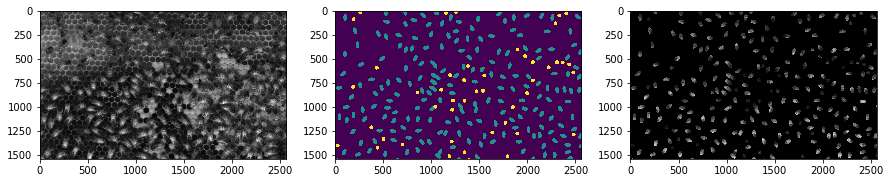

<Figure size 432x288 with 0 Axes>

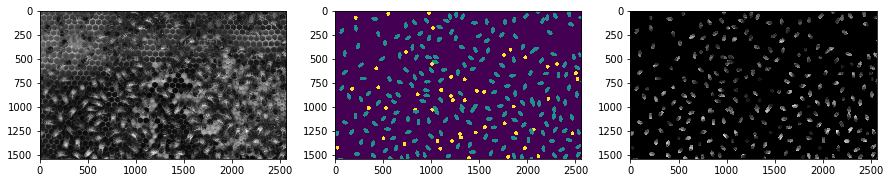

<Figure size 432x288 with 0 Axes>

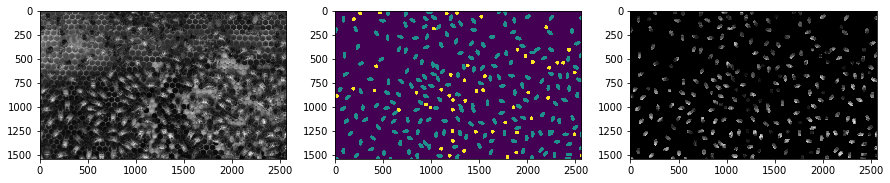

<Figure size 432x288 with 0 Axes>

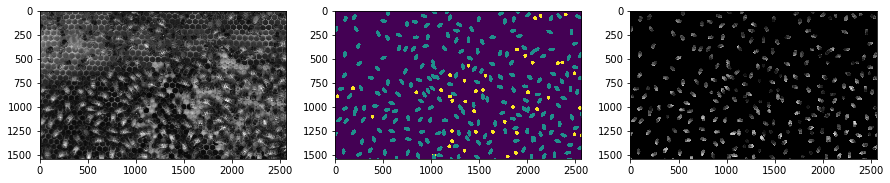

<Figure size 432x288 with 0 Axes>

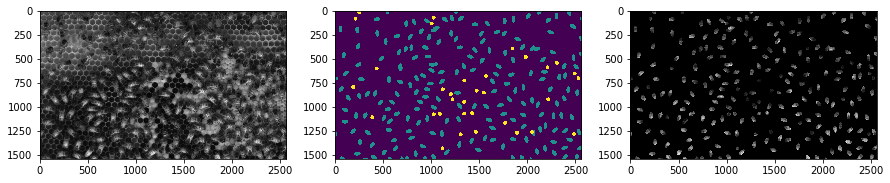

<Figure size 432x288 with 0 Axes>

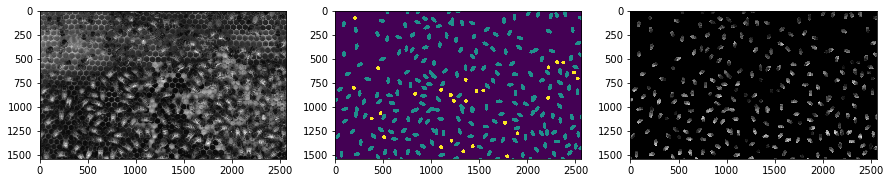

<Figure size 432x288 with 0 Axes>

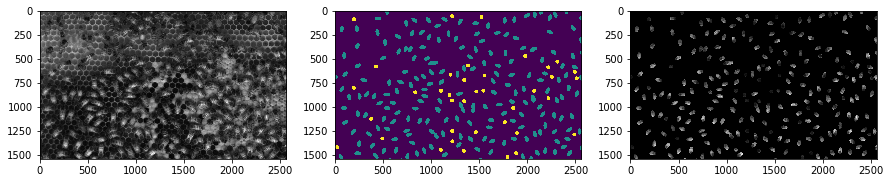

<Figure size 432x288 with 0 Axes>

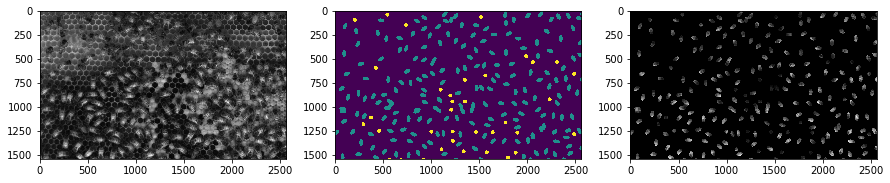

<Figure size 432x288 with 0 Axes>

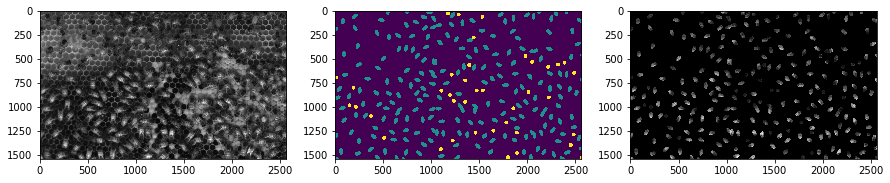

<Figure size 432x288 with 0 Axes>

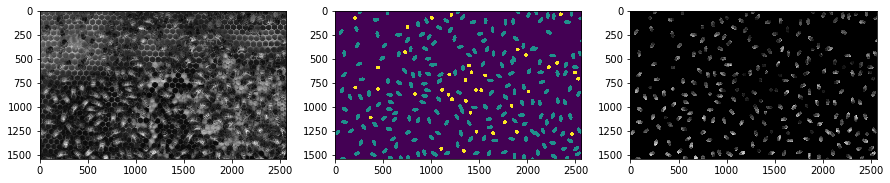

<Figure size 432x288 with 0 Axes>

In [64]:
for f, m in zip(frames, masks): 
    fig, ax = plt.subplots(1,3, figsize=(15,10))
    ax[0].imshow(f, 'gray')
    ax[1].imshow(m)
    
    overlay = f.copy()
    overlay[m==0] = 0

    ax[2].imshow(overlay, cmap='gray')
    
    
    plt.show()
    plt.clf()


# Data handler

In [221]:
CROP_DIM = 512
data_root = 'data'

In [57]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

In [222]:
# Pytorch
import torch
import torchvision
import torch.nn as nn
import torchvision.models
import torch.optim as optim
import torchvision.transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [223]:
class RandomCropper():
    def __init__(self, crop_dim):
        self.crop_dim = crop_dim
        
    def __call__(self, data):
        img, mask = data
        
        img_shape = img.shape

        x1 = np.random.randint(0, img_shape[1]-self.crop_dim)
        y1 = np.random.randint(0, img_shape[0]-self.crop_dim)

        x2 = x1 + self.crop_dim
        y2 = y1 + self.crop_dim

        img = img[y1:y2, x1:x2]
        mask = mask[y1:y2, x1:x2]

        return (img, mask)

In [224]:
class LRFlipper():
    def __init__(self, prob=0.5):
        self.prob = prob
        
    def __call__(self, data):
        img, mask = data
        
        draw = np.random.uniform()
        if draw < self.prob:
            img = np.fliplr(img)
            mask = np.fliplr(mask)

        return (img, mask)

In [225]:
class Rotator():
    def __init__(self, prob=0.75):
        self.prob = prob
        
    def __call__(self, data):
        img, mask = data
        
        
        draw = np.random.uniform()
        if draw < self.prob:
            rand_k = np.random.randint(1,4)
            img = np.rot90(img, k=rand_k)
            mask = np.rot90(mask, k=rand_k)

        return (img, mask)

In [214]:
class BeeDataset(Dataset):
    def __init__(self, data_root, transforms=None):
        self.data_root = data_root
        self.transforms = transforms
        
        self.set_paths()
        
    def set_paths(self):
        print('Loading paths...')
        self.image_paths = np.sort(glob.glob(f'{self.data_root}/images/*.npy'))
        self.mask_paths = np.array([p.replace('/images/', '/masks/') for p in self.image_paths])
        
        # Check for existence
        valid_path_idxs = np.array([os.path.exists(p) for p in self.mask_paths])
        
        if not np.all(valid_path_idxs):
            frac_exist = sum(valid_path_idxs) / len(valid_path_idxs) * 100
            print(f'Fraction of existing image/mask pairs: {frac_exist}')
            
            # Ignore missing pair
            self.image_paths = self.image_paths[valid_path_idxs]
            self.mask_paths = self.mask_paths[valid_path_idxs]
            
        self.n_paths = len(self.image_paths)
        print(f'Num paths loaded: {self.n_paths}')
        
    def __len__(self):
        return self.n_paths
    
    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        
        if self.transforms:
            image, mask = self.transforms((image, mask))
        
        return image, mask

In [215]:
transforms = torchvision.transforms.Compose([
    RandomCropper(CROP_DIM),
    LRFlipper(),
    Rotator()
])

In [218]:
dataset = BeeDataset(data_root=data_root, transforms=transforms)

Loading paths...
Num paths loaded: 10


In [219]:
loader = DataLoader(dataset, batch_size=10)